# Classification of 1000-class ImageNet by VGG
http://aidiary.hatenablog.com/entry/20180212/1518404395

In [1]:
%load_ext autoreload
%autoreload 2

import os, sys 
sys.path.append('..')
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, models, transforms
import json, io, requests
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
!wget https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json

--2019-09-01 11:18:03--  https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.146.61
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.146.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/octet-stream]
Saving to: 'imagenet_class_index.json.1'

imagenet_class_inde 100%[===================>]  34.53K   195KB/s    in 0.2s    

2019-09-01 11:18:04 (195 KB/s) - 'imagenet_class_index.json.1' saved [35363/35363]



In [3]:
#ImageNet Class Label
class_index = json.load(open('imagenet_class_index.json', 'r'))
labels = {int(key):value for (key, value) in class_index.items()}

In [4]:
vgg16 = models.vgg16(pretrained=True)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [5]:
preprocess = transforms.Compose([
    transforms.Resize(256), 
    transforms.CenterCrop(224), 
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

preprocess_check = transforms.Compose([
    transforms.Resize(256), 
    transforms.CenterCrop(224)])

In [6]:
#IMG_URL = 'https://s3.amazonaws.com/mlpipes/pytorch-quick-start/cat.jpg'
IMG_URL = 'https://upload.wikimedia.org/wikipedia/commons/3/35/Joey_Giant_Angora_Buck.jpg'
response = requests.get(IMG_URL)
jpeg_img = Image.open(io.BytesIO(response.content))
print(jpeg_img.size)

(2304, 1728)


torch.Size([1, 3, 224, 224])


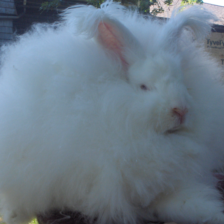

In [7]:
img_tensor = preprocess(jpeg_img)
img_tensor.unsqueeze_(0)
print(img_tensor.size())
preprocess_check(jpeg_img)

In [8]:
out = vgg16(img_tensor)
out = nn.functional.softmax(out, dim=1)
print(out.size())
index = out.max(dim=1)[1].item()
print("Highest Prob.", labels[index])

prob_tsr, idx_tsr = out.topk(5)
predict = {}
for prob, idx in zip(prob_tsr[0], idx_tsr[0]):
    predict[labels[idx.item()][1]] = prob.item()

torch.Size([1, 1000])
Highest Prob. ['n02328150', 'Angora']


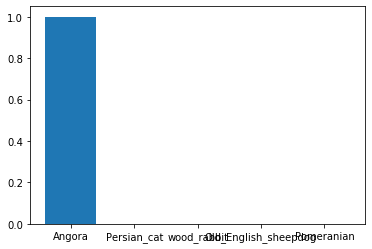

In [9]:
plt.bar(range(len(predict)), list(predict.values()), align='center')
plt.xticks(range(len(predict)), list(predict.keys()))
plt.show()